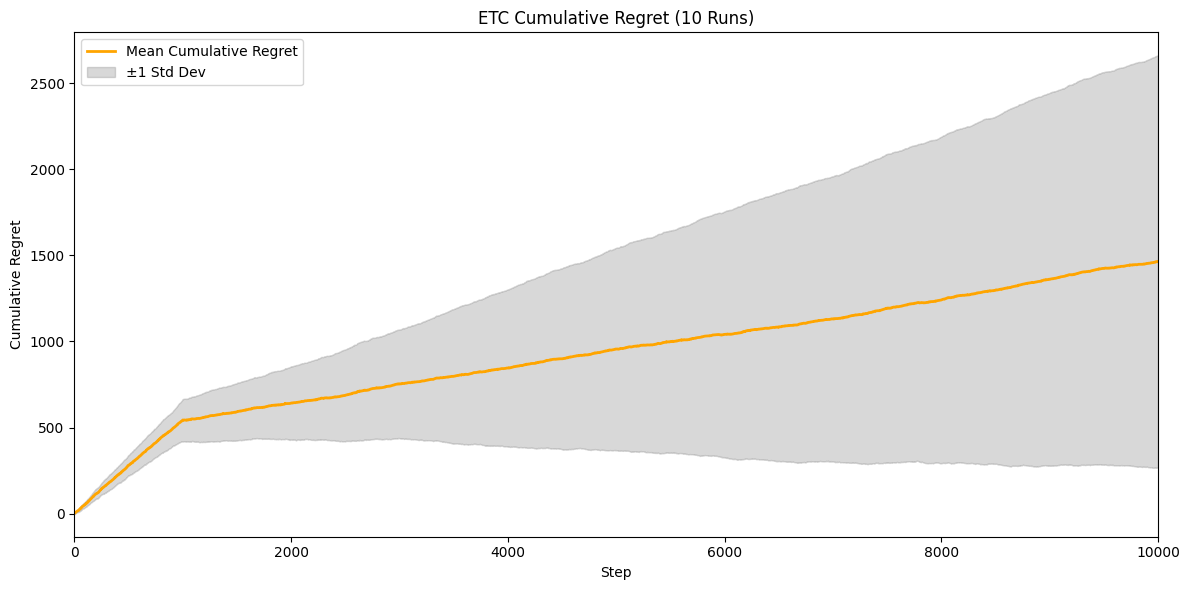

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Load data
ratings = pd.read_csv('ratings.dat', sep='::', engine='python', names=['UserID', 'MovieID', 'Rating', 'Timestamp'])
movies = pd.read_csv('movies.dat', sep='::', engine='python', names=['MovieID', 'Title', 'Genres'], encoding='latin-1')

# Extract the primary genre for each movie
movies['PrimaryGenre'] = movies['Genres'].str.split('|').str[0]

# Merge ratings and movies datasets
merged_data = pd.merge(ratings, movies, on='MovieID')

# Select Rating and PrimaryGenre columns
rating_genres_data = merged_data[['Rating', 'PrimaryGenre']]

# Get all unique genres
unique_genres = rating_genres_data['PrimaryGenre'].unique()

# Group by genres and create a dictionary to store ratings for each genre
genre_ratings = {genre: rating_genres_data[rating_genres_data['PrimaryGenre'] == genre]['Rating'].tolist() for genre in unique_genres}

# ETC strategy
def etc_bandit(K, n, reward_lists):
    m_total = int(0.1 * n)  # Exploration phase total rounds
    rewards, choices, regrets = [], [], []
    empirical_means = np.zeros(K)
    exploration_rewards = [[] for _ in range(K)]
    
    # Exploration phase
    for step in range(m_total):
        arm = step % K
        r = random.choice(reward_lists[arm])
        rewards.append(r)
        choices.append(arm)
        exploration_rewards[arm].append(r)
    
    # Calculate empirical mean rewards for each arm
    for arm in range(K):
        empirical_means[arm] = np.mean(exploration_rewards[arm])
    
    # Calculate the best arm during the exploration phase
    best_arm = int(np.argmax(empirical_means))
    best_arm_mean = empirical_means[best_arm]
    
    # Calculate regrets during the exploration phase
    for t, arm in enumerate(choices[:m_total]):
        regrets.append(best_arm_mean - rewards[t])
    
    # Exploitation phase
    for _ in range(n - m_total):
        r = random.choice(reward_lists[best_arm])
        rewards.append(r)
        choices.append(best_arm)
        regrets.append(best_arm_mean - r)
    
    # Calculate cumulative regrets
    cumulative_regrets = np.cumsum(regrets)
    
    return cumulative_regrets

# Example parameters
K = len(unique_genres)  # Number of arms (primary genres)
n = 10000  # Total time steps
reward_lists = list(genre_ratings.values())  # Use all genres' ratings as reward lists

# Run ETC ten times
num_runs = 10
all_cumulative_regrets = np.zeros((num_runs, n))

# Use different colors for each run
colors = plt.cm.viridis(np.linspace(0, 1, num_runs))

for run in range(num_runs):
    random.seed(time.time())
    np.random.seed(int(time.time()))
    cumulative_regrets = etc_bandit(K, n, reward_lists)
    all_cumulative_regrets[run, :] = cumulative_regrets
    plt.plot(cumulative_regrets, color=colors[run], alpha=0.5, linewidth=1, label=f'Run {run + 1}')

# Calculate average cumulative regret and standard deviation
mean_cumulative_regrets = np.mean(all_cumulative_regrets, axis=0)
std_cumulative_regrets = np.std(all_cumulative_regrets, axis=0)
stderr_cumulative_regrets = std_cumulative_regrets / np.sqrt(num_runs)

# Plot average cumulative regret and error bars
plt.plot(mean_cumulative_regrets, color='red', label='Mean Cumulative Regret', linewidth=2)
plt.fill_between(range(n), 
                 mean_cumulative_regrets - stderr_cumulative_regrets, 
                 mean_cumulative_regrets + stderr_cumulative_regrets, 
                 color='red', alpha=0.3, label='±1 Std Dev')

plt.title('ETC Cumulative Regret (10 Runs)')
plt.xlabel("Step")
plt.ylabel("Cumulative Regret")
plt.xlim(0, n)
plt.legend()
plt.grid(True)
plt.show()